ND

In [2]:
import numpy as np
import copy
import os
import yaml
yaml.Dumper.ignore_aliases = lambda *args : True
import utils
import matplotlib.pyplot as plt
import tqdm
import glob


import importlib
importlib.reload(utils)

<module 'utils' from '/n/home12/cfpark00/ML/ToyCompDiff/utils.py'>

In [ ]:
def get_concept_gradient(xs,ls,n_classes=[2,2]):
    ls_unravel=np.unravel_index(ls,n_classes)
    ls_unravel=np.stack(ls_unravel,axis=-1)
    x_sels=[]
    for dim in range(len(n_classes)):
        x_sels_=[]
        for i_dim in range(n_classes[dim]):
            sel=ls_unravel[:,dim]==i_dim
            x_sel=xs[sel]
            x_sels_.append(x_sel)#.mean(axis=0)) #x_sels_ k_con_i,N_per,C,H,W
        x_sels.append(x_sels_) #x_sels N_concept (k_con_i,N_per,C,H,W)
    cgs=[]
    for x_sels_ in x_sels:
        n_classes_=len(x_sels_)#x_sels_ (k_con_i,N_per,C,H,W)
        mses=[]
        for i in range(n_classes_):
            print(x_sels_[i].shape)
            others=[]
            for j in range(n_classes_):
                if i==j:
                    continue
                if len(x_sels_[j])>0:
                    others.append(x_sels_[j])
            others=np.stack(others,axis=0)
            print(others.shape,x_sels_[i].shape)
            mse=np.mean((others-x_sels_[i][None])**2)
            mses.append(mse)
            #"""
            plt.figure()
            plt.subplot(1,2,1)
            i_rand=np.random.randint(len(others))
            ii_rand=np.random.randint(len(others[i_rand]))
            plt.imshow(others[i_rand][ii_rand].transpose(1,2,0))
            plt.subplot(1,2,2)
            plt.imshow(x_sels_[i][ii_rand].transpose(1,2,0))
            #"""
            assert False
        cgs.append(np.array(mses).mean())
    return np.array(cgs)
    #mse=np.mean((x_sels[0]-x_sels[1])**2)
    #return mse

In [ ]:
def get_concept_gradient(xs,ls,n_classes=[2,2]):
    assert [n_class==2 for n_class in n_classes]
    n_classes=np.array(n_classes)
    l_uniques,counts=np.unique(ls,return_counts=True)
    assert np.unique(counts).shape[0]==1, "Not all classes have the same number of samples"
    #ls_unravel=np.stack(np.unravel_index(ls,n_classes),axis=-1)
    inds_nd=np.stack(np.meshgrid(*[np.arange(n_class) for n_class in n_classes],indexing="ij"),axis=-1).reshape(-1,len(n_classes))
    exists=np.zeros(np.prod(n_classes),dtype=bool)
    for l in l_uniques:
        exists[l]=1
    exists=exists.reshape(n_classes)
    cgs=[]
    for dim in range(len(n_classes)):
        ndim=n_classes[dim]
        sel=exists.sum(axis=dim)>1
        assert sel.sum()>0,"Cannot estimate gradient for concept %d"%dim
        sel=np.expand_dims(sel,dim).repeat(ndim,axis=dim)
        xs_sels={}
        for ind in np.nonzero(sel.flatten())[0]:
            dimval=inds_nd[ind][dim]
            xs_sels.setdefault(dimval,[]).append(xs[ind==ls])
        for dimval in xs_sels:
            xs_sels[dimval]=np.stack(xs_sels[dimval],axis=0)
        mse=((xs_sels[1]-xs_sels[0])**2).mean((1,2,3,4)).mean(0)
        cgs.append(mse)
    cgs=np.array(cgs)
    cgs/=np.linalg.norm(cgs,axis=-1,keepdims=True)
    return cgs

In [2]:
def get_ntr_ntest(ns,n_per=128,method="fid_axis"):
    indsgrid=np.stack(np.meshgrid(*([np.arange(n) for n in ns]),indexing="ij"),axis=-1)
    if method=="fid_axis":
        n_nonzero=np.sum(indsgrid!=0,axis=-1)
        sel=(n_nonzero<=1).flatten().astype(int)
        ntr=(sel*n_per).tolist()
        ntest=((1-sel)*n_per).tolist()
    else:
        raise ValueError("Unknown method")
    return ntr,ntest

In [3]:
config={
    'experiment_directory': None,
    'seed': None,
    "dataset":"images_1",
    'n_samples_train':[],
    'n_samples_test':[],
    'n_samples_train_gen':[],
    'n_samples_test_gen':[],
    "data_params":{
        "n_classes":64,
        "image_size": 32,
        "noise_level": 0.001,
        "comp_dims":{"shape":None,"x":None,"y":None,"color":2,"size":2,"bg_color":2},
        
        #"shape":{"names":["circle","triangle"]},#will default to circle
        "x":{"min":-0.5,"max":0.5,"n":None,"s":0.05,"s_n":0.0},
        "y":{"min":-0.5,"max":0.5,"n":None,"s":0.05,"s_n":0.0},
        "color":{"means":[[0.9,0.1,0.1],[0.1,0.1,0.9]],"mins":[[0.8,0.0,0.0],[0.0,0.0,0.8]],"maxs":[[1.0,0.2,0.2],[0.2,0.2,1.0]],"s_n":0.0},
        "size":{"means":[0.6,0.2],"mins":[0.52,0.12],"maxs":[0.68,0.28],"s_n":0.00,"min":0.1},
        "bg_color":{"means":[[0.9,0.9,0.9],[0.1,0.1,0.1]],"mins":[[0.8,0.8,0.8],[0.0,0.0,0.0]],"maxs":[[1.0,1.0,1.0],[0.2,0.2,0.2]],"s_n":0.0},
    },
    "model_params":{
        "model_type": "VDiff",
        "optimizer_type": "AdamW",
        "optimizer_params": {"lr": 0.001,"weight_decay": 0.01},
        "data_noise":1e-3,
        "beta_settings": {"type":"logsnr","noise_schedule":"learned_linear","gamma_min":-5., "gamma_max":10.},
        "network_params": {"mid_attn":True,
                           "v_conditioning_type":"sep_mlp",
                           "v_conditioning_dims":[11],
                           "chs": [64,128,256],
                           "num_res_blocks":2,
                           "init_scale":1.0},
    },
    "batch_size": 64,
    "train_ratio": 0.85,
    'num_steps': 20_000,
    'save_steps_start': 500,
    'save_steps': 60,

    "fig_n_col": 4,
}

2x2

In [4]:
ntr,ntest=get_ntr_ntest([2,2],n_per=2048,method="fid_axis")
ntr_gen,ntest_gen=get_ntr_ntest([2,2],n_per=32,method="fid_axis")
np.sum(ntr),np.sum(ntest),np.sum(ntr_gen),np.sum(ntest_gen)

(6144, 2048, 96, 32)

In [5]:
hss=0.1
0.45-(7/4)*hss

0.275

In [6]:
def get_config(sep_col=0.8,sep_size=0.4,seed=0):
    assert sep_col<=0.8 and sep_size<=0.4
    config_=copy.deepcopy(config)
    config_["seed"]=seed

    config_["data_params"]["n_classes"]=4
    config_["data_params"]["comp_dims"]["bg_color"]=None
    #color
    hsc=sep_col/2
    config_["data_params"]["color"]["means"]=[[0.5+hsc,0.5-hsc,0.5-hsc],[0.5-hsc,0.5-hsc,0.5+hsc]]
    s=sep_col/8
    config_["data_params"]["color"]["mins"]=[[0.5+hsc-s,0.5-hsc-s,0.5-hsc-s],[0.5-hsc-s,0.5-hsc-s,0.5+hsc-s]]
    config_["data_params"]["color"]["maxs"]=[[0.5+hsc+s,0.5-hsc+s,0.5-hsc+s],[0.5-hsc+s,0.5-hsc+s,0.5+hsc+s]]
    #size
    hss=sep_size/2
    config_["data_params"]["size"]["means"]=[0.45+hss,0.45-hss]
    s=sep_size*3/8
    config_["data_params"]["size"]["mins"]=[0.45+hss-s,0.45-hss-s]
    config_["data_params"]["size"]["maxs"]=[0.45+hss+s,0.45-hss+s]
    return config_

In [71]:
def get_concept_gradient(xs,ls,n_classes=[2,2]):
    ls_unravel=np.unravel_index(ls,n_classes)
    ls_unravel=np.stack(ls_unravel,axis=-1)
    x_sels=[]
    for dim in range(len(n_classes)):
        x_sels_=[]
        for i_dim in range(n_classes[dim]):
            sel=ls_unravel[:,dim]==i_dim
            x_sel=xs[sel]
            x_sels_.append(x_sel)#.mean(axis=0)) #x_sels_ k_con_i,N_per,C,H,W
        x_sels.append(x_sels_) #x_sels N_concept (k_con_i,N_per,C,H,W)
    cgs=[]
    for x_sels_ in x_sels:
        n_classes_=len(x_sels_)#x_sels_ (k_con_i,N_per,C,H,W)
        mses=[]
        for i in range(n_classes_):
            print(x_sels_[i].shape)
            others=[]
            for j in range(n_classes_):
                if i==j:
                    continue
                if len(x_sels_[j])>0:
                    others.append(x_sels_[j])
            others=np.stack(others,axis=0)
            print(others.shape,x_sels_[i].shape)
            mse=np.mean((others-x_sels_[i][None])**2)
            mses.append(mse)
            #"""
            plt.figure()
            plt.subplot(1,2,1)
            i_rand=np.random.randint(len(others))
            ii_rand=np.random.randint(len(others[i_rand]))
            plt.imshow(others[i_rand][ii_rand].transpose(1,2,0))
            plt.subplot(1,2,2)
            plt.imshow(x_sels_[i][ii_rand].transpose(1,2,0))
            #"""
            assert False
        cgs.append(np.array(mses).mean())
    return np.array(cgs)
    #mse=np.mean((x_sels[0]-x_sels[1])**2)
    #return mse

In [164]:
def get_concept_gradient(xs,ls,n_classes=[2,2]):
    assert [n_class==2 for n_class in n_classes]
    n_classes=np.array(n_classes)
    l_uniques,counts=np.unique(ls,return_counts=True)
    assert np.unique(counts).shape[0]==1, "Not all classes have the same number of samples"
    #ls_unravel=np.stack(np.unravel_index(ls,n_classes),axis=-1)
    inds_nd=np.stack(np.meshgrid(*[np.arange(n_class) for n_class in n_classes],indexing="ij"),axis=-1).reshape(-1,len(n_classes))
    exists=np.zeros(np.prod(n_classes),dtype=bool)
    for l in l_uniques:
        exists[l]=1
    exists=exists.reshape(n_classes)
    cgs=[]
    for dim in range(len(n_classes)):
        ndim=n_classes[dim]
        sel=exists.sum(axis=dim)>1
        assert sel.sum()>0,"Cannot estimate gradient for concept %d"%dim
        sel=np.expand_dims(sel,dim).repeat(ndim,axis=dim)
        xs_sels={}
        for ind in np.nonzero(sel.flatten())[0]:
            dimval=inds_nd[ind][dim]
            xs_sels.setdefault(dimval,[]).append(xs[ind==ls])
        for dimval in xs_sels:
            xs_sels[dimval]=np.stack(xs_sels[dimval],axis=0)
        mse=((xs_sels[1]-xs_sels[0])**2).mean((1,2,3,4)).mean(0)
        cgs.append(mse)
    cgs=np.array(cgs)
    cgs/=np.linalg.norm(cgs,axis=-1,keepdims=True)
    return cgs

In [149]:
xs=np.concatenate([x_tr,x_te],axis=0)
ls=np.concatenate([l_tr,l_te],axis=0)

In [151]:
xs=x_tr
ls=l_tr

In [152]:
get_concept_gradient(xs,ls,n_classes=[2,2])

array([0.00520534, 0.01710206], dtype=float32)

In [39]:
configs_=[]
for sep_col in [0.2,0.4,0.6,0.8]:
    for sep_size in [0.1,0.2,0.3,0.4]:
        for seed in range(5):
            fol=f"images_1/2x2_final2/sc4ss4/sep_col={sep_col}_sep_size={sep_size}"
            experiment_name=f"seed={seed}"
            config_=get_config(sep_col=sep_col,sep_size=sep_size,seed=seed)
            config_['n_samples_train']=ntr
            config_['n_samples_test']=ntest_gen #intentional
            config_['n_samples_train_gen']=ntr_gen
            config_['n_samples_test_gen']=ntest_gen
            config_["fig_n_col"]=2
            config_=utils.process_config(config_,check_only=True)
            experiment_directory=os.path.join("data",fol,experiment_name)
            config_["experiment_directory"]=experiment_directory
            yaml_fol=os.path.join("yamls",fol)
            os.makedirs(yaml_fol,exist_ok=True)
            yaml_path=os.path.join(yaml_fol,experiment_name+".yaml")
            yaml.dump(config_,open(yaml_path,"w"))
            configs_.append(config_)

In [43]:
yaml_files=glob.glob("./yamls/images_1/2x2_final2/sc4ss4/*/*.yaml")

n_proc=10
chunked=[yaml_files[i::n_proc] for i in range(n_proc)]
for i,chunk in enumerate(chunked):
    with open(f"./yamls/images_1/2x2_final2/sc4ss4/yamls_{i}.txt","w") as f:
        for path in chunk:
            path=os.path.abspath(path)
            f.write(path+"\n")

In [9]:
configs_detailed=[]
for sep_col in [0.2,0.3,0.4,0.5,0.6,0.7,0.8]:
    for sep_size in [0.2,0.233,0.266,0.3,0.333,0.366,0.4]:
        for seed in [0,100,200,300,400]:
            fol=f"images_1/2x2_final2/detailed/sep_col={sep_col}_sep_size={sep_size}"
            experiment_name=f"seed={seed}"
            config_=get_config(sep_col=sep_col,sep_size=sep_size,seed=seed)
            config_['n_samples_train']=ntr
            config_['n_samples_test']=ntest_gen #intentional
            config_['n_samples_train_gen']=ntr_gen
            config_['n_samples_test_gen']=ntest_gen
            config_["save_ckpts"]=False
            config_["fig_n_col"]=2
            config_=utils.process_config(config_,check_only=True)
            experiment_directory=os.path.join("data",fol,experiment_name)
            config_["experiment_directory"]=experiment_directory
            yaml_fol=os.path.join("yamls",fol)
            os.makedirs(yaml_fol,exist_ok=True)
            yaml_path=os.path.join(yaml_fol,experiment_name+".yaml")
            yaml.dump(config_,open(yaml_path,"w"))
            configs_detailed.append(config_)

In [45]:
import glob
import os
yaml_files=glob.glob("./yamls/images_1/2x2_final2/detailed/*/*.yaml")

n_proc=10
chunked=[yaml_files[i::n_proc] for i in range(n_proc)]
for i,chunk in enumerate(chunked):
    with open(f"./yamls/images_1/2x2_final2/detailed/yamls_{i}.txt","w") as f:
        for path in chunk:
            path=os.path.abspath(path)
            f.write(path+"\n")

In [156]:
configs_col_sweep=[]
for sep_col in [0.1  , 0.137, 0.174, 0.211, 0.247, 0.284, 0.321, 0.358, 0.395,
0.432, 0.468, 0.505, 0.542, 0.579, 0.616, 0.653, 0.689, 0.726,
       0.763, 0.8  ]:
    for sep_size in [0.4]:
        for seed in [0,100,200,300,400]:
            fol=f"images_1/2x2_final2/col_sweep/sep_col={sep_col}_sep_size={sep_size}"
            experiment_name=f"seed={seed}"
            config_=get_config(sep_col=sep_col,sep_size=sep_size,seed=seed)
            config_['n_samples_train']=ntr
            config_['n_samples_test']=ntest_gen #intentional
            config_['n_samples_train_gen']=ntr_gen
            config_['n_samples_test_gen']=ntest_gen
            config_["save_ckpts"]=False
            config_["fig_n_col"]=2
            config_=utils.process_config(config_,check_only=True)
            experiment_directory=os.path.join("data",fol,experiment_name)
            config_["experiment_directory"]=experiment_directory
            yaml_fol=os.path.join("yamls",fol)
            os.makedirs(yaml_fol,exist_ok=True)
            yaml_path=os.path.join(yaml_fol,experiment_name+".yaml")
            yaml.dump(config_,open(yaml_path,"w"))
            configs_col_sweep.append(config_)

In [53]:
import glob
import os
yaml_files=glob.glob("./yamls/images_1/2x2_final2/col_sweep/*/*.yaml")

n_proc=4
chunked=[yaml_files[i::n_proc] for i in range(n_proc)]
for i,chunk in enumerate(chunked):
    with open(f"./yamls/images_1/2x2_final2/col_sweep/yamls_{i}.txt","w") as f:
        for path in chunk:
            path=os.path.abspath(path)
            f.write(path+"\n")

In [157]:
configs_size_sweep=[]
for sep_col in [0.4]:
    for sep_size in [0.2  , 0.211, 0.221, 0.232, 0.242, 0.253, 0.263, 0.274, 0.284,
       0.295, 0.305, 0.316, 0.326, 0.337, 0.347, 0.358, 0.368, 0.379,
       0.389, 0.4  ]:
        for seed in [0,100,200,300,400]:
            fol=f"images_1/2x2_final2/size_sweep/sep_col={sep_col}_sep_size={sep_size}"
            experiment_name=f"seed={seed}"
            config_=get_config(sep_col=sep_col,sep_size=sep_size,seed=seed)
            config_['n_samples_train']=ntr
            config_['n_samples_test']=ntest_gen #intentional
            config_['n_samples_train_gen']=ntr_gen
            config_['n_samples_test_gen']=ntest_gen
            config_["save_ckpts"]=False
            config_["fig_n_col"]=2
            config_=utils.process_config(config_,check_only=True)
            experiment_directory=os.path.join("data",fol,experiment_name)
            config_["experiment_directory"]=experiment_directory
            yaml_fol=os.path.join("yamls",fol)
            os.makedirs(yaml_fol,exist_ok=True)
            yaml_path=os.path.join(yaml_fol,experiment_name+".yaml")
            yaml.dump(config_,open(yaml_path,"w"))
            configs_size_sweep.append(config_)

In [56]:
import glob
import os
yaml_files=glob.glob("./yamls/images_1/2x2_final2/size_sweep/*/*.yaml")

n_proc=4
chunked=[yaml_files[i::n_proc] for i in range(n_proc)]
for i,chunk in enumerate(chunked):
    with open(f"./yamls/images_1/2x2_final2/size_sweep/yamls_{i}.txt","w") as f:
        for path in chunk:
            path=os.path.abspath(path)
            f.write(path+"\n")

In [165]:
cgs=[]
include_te=False
for config_ in tqdm.tqdm([*configs_col_sweep[::5],*configs_size_sweep[::5]]):
#for config_ in tqdm.tqdm([*configs_detailed[::5]]):
    config__=copy.deepcopy(config_)
    if include_te:
        ntr,ntest=get_ntr_ntest([2,2],n_per=2048,method="fid_axis")
        config__['n_samples_train']=ntr
        config__['n_samples_test']=ntest
    else:
        ntr,ntest=get_ntr_ntest([2,2],n_per=2048,method="fid_axis")
        config__['n_samples_train']=ntr
        config__['n_samples_test']=[0 for _ in ntest]
    seed=np.random.randint(1000)
    x_tr,y_tr,l_tr,x_te,y_te,l_te=utils.generate_data(config__,seed=seed)
    if include_te:
        xs=np.concatenate([x_tr,x_te],axis=0)
        ls=np.concatenate([l_tr,l_te],axis=0)
    else:
        xs=x_tr
        ls=l_tr
    cgs_=get_concept_gradient(xs,ls,n_classes=[2,2])
    cgs.append(cgs_)
cgs=np.stack(cgs,axis=0)
cgs.shape

100%|██████████| 40/40 [01:03<00:00,  1.59s/it]


(40, 2)

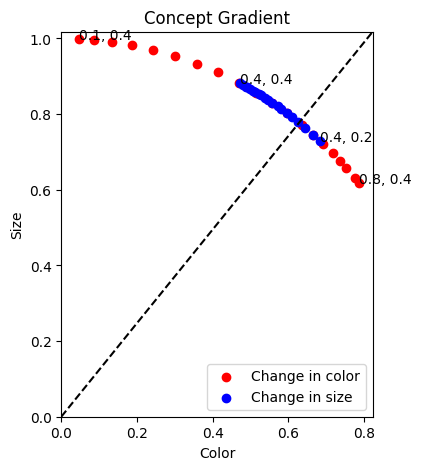

In [169]:
_=plt.figure(figsize=(5,5))
for i in range(20):
    sep_col=[0.1  , 0.137, 0.174, 0.211, 0.247, 0.284, 0.321, 0.358, 0.395,
0.432, 0.468, 0.505, 0.542, 0.579, 0.616, 0.653, 0.689, 0.726,
       0.763, 0.8  ][i]
    sep_size=0.4
    plt.scatter(cgs[i,0],cgs[i,1],c="r",label="Change in color" if i==0 else None)
    if i==0 or i==19:
        plt.annotate(f"{sep_col}, {sep_size}",(cgs[i,0],cgs[i,1]))
for i in range(20):
    sep_col=0.4
    sep_size=[0.2  , 0.211, 0.221, 0.232, 0.242, 0.253, 0.263, 0.274, 0.284,
    0.295, 0.305, 0.316, 0.326, 0.337, 0.347, 0.358, 0.368, 0.379,
    0.389, 0.4  ][i]
    plt.scatter(cgs[i+20,0],cgs[i+20,1],c="b",label="Change in size" if i==0 else None)
    if i==0 or i==19:
        plt.annotate(f"{sep_col}, {sep_size}",(cgs[i+20,0],cgs[i+20,1]))
plt.xlabel("Color")
plt.ylabel("Size")
plt.title("Concept Gradient")
plt.gca().set_aspect('equal')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.legend()
xlim=plt.gca().get_xlim()
ylim=plt.gca().get_ylim()
plt.xlim(xlim)
plt.ylim(ylim)
plt.plot(xlim,ylim,c="k",ls="--")

In [163]:
np.save("./cg_col_sweep.npy",cgs[:20])
np.save("./cg_size_sweep.npy",cgs[20:])

In [85]:
def get_config(sep_col=0.8,sep_size=0.4,seed=0):
    assert sep_col<=0.8 and sep_size
    config_=copy.deepcopy(config)
    config_["seed"]=seed

    config_["data_params"]["n_classes"]=4
    config_["data_params"]["comp_dims"]["bg_color"]=None
    #color
    hsc=sep_col/2
    config_["data_params"]["color"]["means"]=[[0.5+hsc,0.5-hsc,0.5-hsc],[0.5-hsc,0.5-hsc,0.5+hsc]]
    s=sep_col/8
    config_["data_params"]["color"]["mins"]=[[0.5+hsc-s,0.5-hsc-s,0.5-hsc-s],[0.5-hsc-s,0.5-hsc-s,0.5+hsc-s]]
    config_["data_params"]["color"]["maxs"]=[[0.5+hsc+s,0.5-hsc+s,0.5-hsc+s],[0.5-hsc+s,0.5-hsc+s,0.5+hsc+s]]
    #size
    hss=sep_size/2
    config_["data_params"]["size"]["means"]=[0.45+hss,0.45-hss]
    s=sep_size/8
    config_["data_params"]["size"]["mins"]=[0.45+hss-s,0.45-hss-s]
    config_["data_params"]["size"]["maxs"]=[0.45+hss+s,0.45-hss+s]
    return config_

In [86]:
configs_=[]
for sep_col in [0.2,0.5,0.8]:
    for sep_size in [0.2,0.4]:
        for seed in range(5):
            fol=f"images_1/2x2_final2/sc3ss2_snarrow/sep_col={sep_col}_sep_size={sep_size}"
            experiment_name=f"seed={seed}"
            config_=get_config(sep_col=sep_col,sep_size=sep_size,seed=seed)
            config_['n_samples_train']=ntr
            config_['n_samples_test']=ntest_gen #intentional
            config_['n_samples_train_gen']=ntr_gen
            config_['n_samples_test_gen']=ntest_gen
            config_["fig_n_col"]=2
            config_=utils.process_config(config_,check_only=True)
            experiment_directory=os.path.join("data",fol,experiment_name)
            config_["experiment_directory"]=experiment_directory
            yaml_fol=os.path.join("yamls",fol)
            os.makedirs(yaml_fol,exist_ok=True)
            yaml_path=os.path.join(yaml_fol,experiment_name+".yaml")
            yaml.dump(config_,open(yaml_path,"w"))
            configs_.append(config_)

In [87]:
import glob
import os
yaml_files=glob.glob("./yamls/images_1/2x2_final2/sc3ss2_snarrow/*/*.yaml")

n_proc=10
chunked=[yaml_files[i::n_proc] for i in range(n_proc)]
for i,chunk in enumerate(chunked):
    with open(f"yamls_2_{i}.txt","w") as f:
        for path in chunk:
            path=os.path.abspath(path)
            f.write(path+"\n")

In [137]:
cgs=[]
for config_ in tqdm.tqdm(configs_):
    config__=copy.deepcopy(config_)
    config__['n_samples_test']=ntest #for c.g. estimation
    seed=np.random.randint(1000)
    x_tr,y_tr,l_tr,x_te,y_te,l_te=utils.generate_data(config__,seed=seed)
    xs=np.concatenate([x_tr,x_te],axis=0)
    ls=np.concatenate([l_tr,l_te],axis=0)
    xs=np.concatenate([x_tr,x_te],axis=0)
    ls=np.concatenate([l_tr,l_te],axis=0)
    cgs_=get_concept_gradient(xs,ls,n_classes=[2,2])
    cgs.append(cgs_)
cgs=np.stack(cgs,axis=0).reshape(4,4,5,-1)

100%|██████████| 80/80 [03:10<00:00,  2.38s/it]


In [131]:
cgs

[array([0.00490427, 0.00675259], dtype=float32)]

In [125]:
x_tr.shape

(6144, 3, 32, 32)

In [126]:
config_["n_samples_train"]

[2048, 2048, 2048, 0]

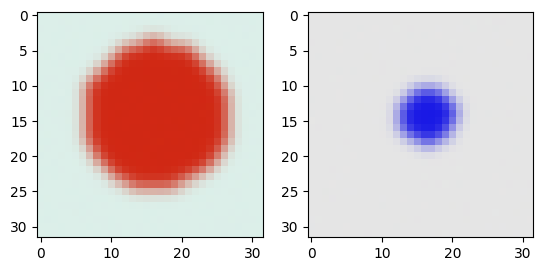

In [127]:
plt.subplot(1,2,1)
plt.imshow(x_tr[l_tr==0][0].transpose(1,2,0))
plt.subplot(1,2,2)
plt.imshow(x_te[l_te==3][0].transpose(1,2,0))

Text(0.5, 1.0, 'Concept Gradient')

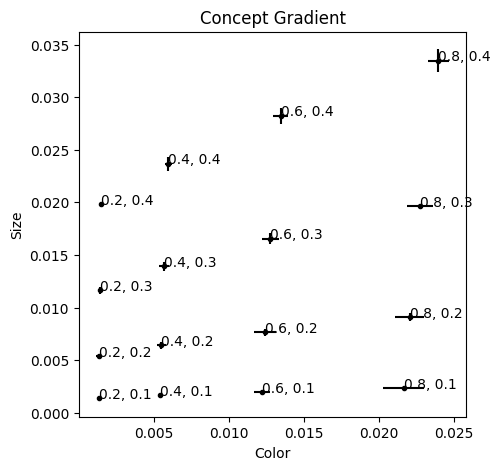

In [128]:
_=plt.figure(figsize=(5,5))
mcgs=cgs.mean(axis=-2)
scgs=cgs.std(axis=-2)
for i in range(4):
    for j in range(4):
        sep_col=[0.2,0.4,0.6,0.8][i]
        sep_size=[0.1,0.2,0.3,0.4][j]
        plt.errorbar(mcgs[i,j,0],mcgs[i,j,1],xerr=5*scgs[i,j,0],yerr=5*scgs[i,j,1],fmt='.',c="black")
        plt.annotate(f"{sep_col}, {sep_size}",(mcgs[i,j,0],mcgs[i,j,1]))
plt.xlabel("Color")
plt.ylabel("Size")
plt.title("Concept Gradient")

In [19]:
config_=configs_[11]
x_tr,y_tr,l_tr,x_te,y_te,l_te=utils.generate_data(config_)

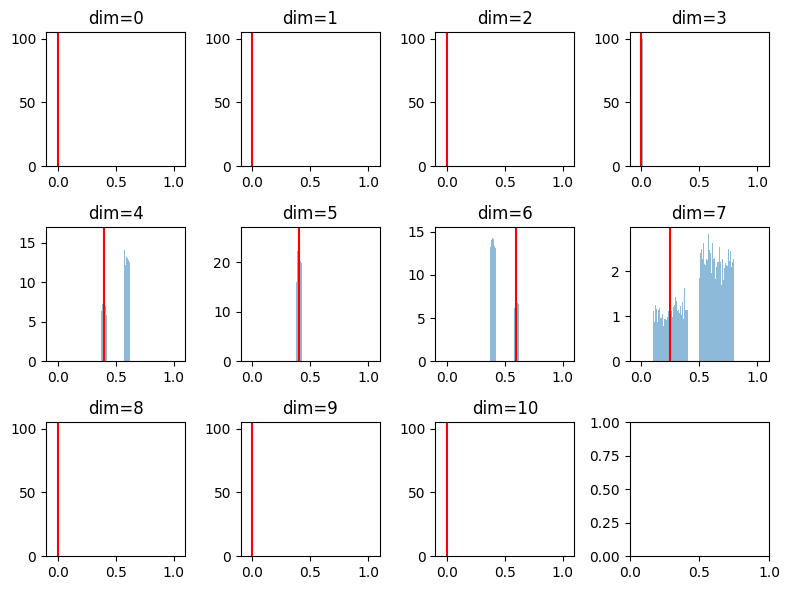

In [20]:
import matplotlib.pyplot as plt
import tqdm
fig,axs=plt.subplots(3,4,figsize=(8,6))
for dim in range(y_tr.shape[1]):
    ax=axs.flatten()[dim]
    l_te_unique=np.unique(l_te)
    y_tes=[y_te[l_te==l][0,dim] for l in l_te_unique]
    ax.hist(y_tr[:,dim],bins=100,density=True,alpha=0.5)
    for y in y_tes:
        ax.axvline(y,color="r")
    ax.set_title(f"dim={dim}")
    ax.set_xlim(-0.1,1.1)
plt.tight_layout()

In [121]:
cgs_col=[]
cgs_size=[]
for sep_col in tqdm.tqdm([0.2,0.4,0.6,0.8]):
    for sep_size in [0.1,0.2,0.3,0.4]:
        config_=get_config(sep_col=sep_col,sep_size=sep_size,seed=0)
        x_tr,y_tr,l_tr,x_te,y_te,l_te=utils.generate_data(config_)
        x_all=np.concatenate([x_tr,x_te],axis=0)
        l_all=np.concatenate([l_tr,l_te],axis=0)
        cgs_col.append(get_concept_gradient(x_all,l_all,n_classes=[2,2],dim=0))
        cgs_size.append(get_concept_gradient(x_all,l_all,n_classes=[2,2],dim=1))
cgs_col=np.array(cgs_col).reshape(4,4)
cgs_size=np.array(cgs_size).reshape(4,4)
cgs_col.shape,cgs_size.shape

100%|██████████| 4/4 [00:25<00:00,  6.39s/it]


((4, 4), (4, 4))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


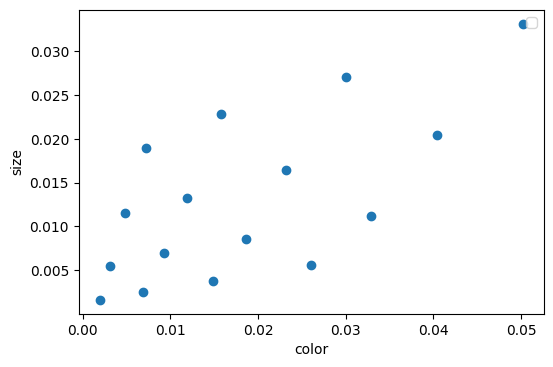

In [122]:
plt.figure(figsize=(6,6))
plt.scatter(cgs_col,cgs_size)
plt.xlabel("color")
plt.ylabel("size")
plt.gca().set_aspect('equal')
plt.legend()

In [93]:
#fcns
get_concept_gradient(x_all,l_all,n_classes=[2,2],dim=0),get_concept_gradient(x_all,l_all,n_classes=[2,2],dim=1)

(0.026341906, 0.0056774877)

In [86]:
#ncns
get_concept_gradient(x_all,l_all,n_classes=[2,2],dim=0),get_concept_gradient(x_all,l_all,n_classes=[2,2],dim=1)

(0.0069876052, 0.0025821605)

In [74]:
#ncfs
get_concept_gradient(x_all,l_all,n_classes=[2,2],dim=0),get_concept_gradient(x_all,l_all,n_classes=[2,2],dim=1)

(0.01604486, 0.022749947)

In [66]:
#fcfs
# get_concept_gradient(x_all,l_all,n_classes=[2,2],dim=0),get_concept_gradient(x_all,l_all,n_classes=[2,2],dim=1)

(0.04904562, 0.032170534)

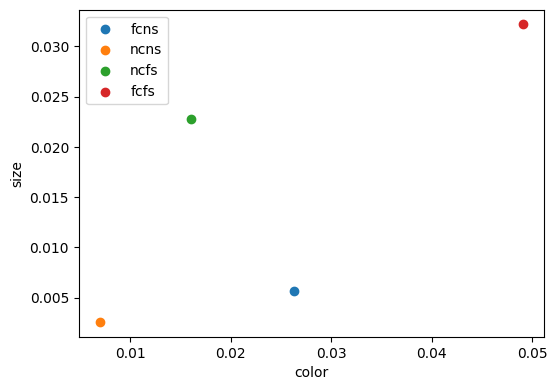

In [99]:
plt.figure(figsize=(6,6))
_=plt.scatter(0.026341906, 0.0056774877,label="fcns")
_=plt.scatter(0.0069876052, 0.0025821605,label="ncns")
_=plt.scatter(0.01604486, 0.022749947,label="ncfs")
_=plt.scatter(0.04904562, 0.032170534,label="fcfs")
plt.xlabel("color")
plt.ylabel("size")
plt.gca().set_aspect('equal')
plt.legend()

In [15]:
model.get_loss

<bound method GenVDiff.get_loss of GenVDiff(
  (model): VDM(
    (score_model): CUNet(
      (embed_t_conditioning): Sequential(
        (0): Linear(in_features=64, out_features=256, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=256, out_features=256, bias=True)
        (3): GELU(approximate='none')
      )
      (embeds_v_conditionings): ModuleList(
        (0): Identity()
      )
      (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (downs): ModuleList(
        (0): ResNetDown(
          (resnet_blocks): ModuleList(
            (0-1): 2 x ResNetBlock(
              (net1): Sequential(
                (0): GroupNorm(8, 64, eps=1e-06, affine=True)
                (1): GELU(approximate='none')
                (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              )
              (cond_projs): ModuleList(
                (0): Sequential(
                  (0): Linear(in_features=256, out_fe

In [ ]:
    config_["data_params"]["size"]["means"]=[0.5,0.3]
    config_["data_params"]["size"]["mins"]=[0.5-0.04,0.3-0.04]
    config_["data_params"]["size"]["maxs"]=[0.5+0.04,0.3+0.04]

In [21]:
fol="images_1/2x2/ncns_fast"
for seed in range(3):
    experiment_name=f"seed={seed}"

    config_=copy.deepcopy(config)
    config_["seed"]=seed

    config_["data_params"]["n_classes"]=4
    config_["data_params"]["comp_dims"]["bg_color"]=None
    config_["data_params"]["color"]["means"]=[[0.55,0.45,0.45],[0.45,0.45,0.55]]
    config_["data_params"]["color"]["mins"]=[[0.54875,0.44875,0.44875],[0.44875,0.44875,0.54875]]
    config_["data_params"]["color"]["maxs"]=[[0.55125,0.45125,0.45125],[0.45125,0.45125,0.55125]]
    config_["data_params"]["size"]["means"]=[0.5,0.3]
    config_["data_params"]["size"]["mins"]=[0.5-0.04,0.3-0.04]
    config_["data_params"]["size"]["maxs"]=[0.5+0.04,0.3+0.04]

    config_['n_samples_train']=ntr
    config_['n_samples_test']=ntest_gen #intentional
    config_['n_samples_train_gen']=ntr_gen
    config_['n_samples_test_gen']=ntest_gen

    config_["fig_n_col"]=2
    
    config_=utils.process_config(config_,check_only=True)
    experiment_directory=os.path.join("data",fol,experiment_name)
    config_["experiment_directory"]=experiment_directory
    yaml_fol=os.path.join("yamls",fol)
    os.makedirs(yaml_fol,exist_ok=True)
    yaml_path=os.path.join(yaml_fol,experiment_name+".yaml")
    yaml.dump(config_,open(yaml_path,"w"))

2x2x2

In [7]:
ntr,ntest=get_ntr_ntest([2,2,2],n_per=2048,method="fid_axis")
ntr_gen,ntest_gen=get_ntr_ntest([2,2,2],n_per=32,method="fid_axis")
np.sum(ntr),np.sum(ntest),np.sum(ntr_gen),np.sum(ntest_gen)

(8192, 8192, 128, 128)